## StochPy 
### Stochastic Simulations

This small tutorial is going to show how to use the module **stochpy** and how to mix it with **Moonlight** to do *parameter synthesis*. 

We will use the default model, that is "ImmigrationDeath.psc". $\newline$
  

From **stochpy** documentation
>    We call this the Immigration-death model which we use as the default model in StochPy. Here, we define two reactions: a zero-order reaction R1 synthesizing the species mRNA and a first-order reaction R1 degrading mRNA. Next, we set an initial mRNA copy number and finally the parameter values of the synthesis and degradation rate.

The first reaction is associated with parameter Ksyn, the second one with Kdeg.
The mRNA initial value is fixed, but it can be changed.

All the stochpy example models are saved in 'C:/Stochpy/pscmodels'. 

(Might be different if you are not using Windows. After compiling the cell with the modules, a small description of StochPy will tell you where model folder is.) 


For more insights on the StochPy module, follow the online documentation: 
-    https://pythonhosted.org/StochPy/modules_doc.html
-    http://stochpy.sourceforge.net/html/userguide_doc.html


In [1]:
import numpy as np
import random
import math

from moonlight import *

import stochpy

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 10) 
from matplotlib import colors



#######################################################################
#                                                                     #
#            Welcome to the interactive StochPy environment           #
#                                                                     #
#######################################################################
#  StochPy: Stochastic modeling in Python                             #
#  http://stochpy.sourceforge.net                                     #
#  Copyright(C) T.R Maarleveld, B.G. Olivier, F.J Bruggeman 2010-2015 #
#  DOI: 10.1371/journal.pone.0079345                                  #
#  Email: tmd200@users.sourceforge.net                                #
#  VU University, Amsterdam, Netherlands                              #
#  Centrum Wiskunde Informatica, Amsterdam, Netherlands               #
#  StochPy is distributed under the BSD licence.                      #
###############################################################

The following functions simulate the Immigration-Death model from the StochPy module.

It is prepare to run using default parameters. 
Some details will be printed directly by the function *StochasticModellingWithParameters()*.

If you want to inspect the functions, they have a bit of documentation.
-    ImmigrationDeathSSA(Ksyn, Kdeg, ltime, n_samples): it simulates one time the model using the parameters in input. It return the SSA, so it can be inspected indipendently as stochpy object;

-    getSpeciesTimeSeriesAsArray(ssa): using some inner stochpy notation, it is possible to extract the trajectories from the simulation. It takes in input the SSA object and returns an multi-dimensional array, where the first position refers to the trajectory, the others are the time steps and the value;

-    StochModel(n_traj, ltime, Ksyn, Kdeg): one run of this function will simulate a set of *n_traj* trajectories for the couple of parameters in input, each of length *ltime*. It return a couple of values: they are the average robustness for the two formulas used for the monitoring;

-    StochasticModellingWithParameters(ltime, n_traj, parameterKsyn, parameterKdeg, model): this function repeats the simulation for all the possible couple of parameters $(Ksyn, Kdeg) \in \text{parametersKsyn} \times \text{parametersKdeg}$. 

They take parameter in input such as the length of the time interval, the number of trajectories for each run, the parameters, ..
This is already set up by default to have nice results, but inspecting the code you can change a lot of details, like the set of parameters, the formulas, the time interval, ...

The default function takes a half a minute to execute. 



In [5]:
def ImmigrationDeathSSA(Ksyn, Kdeg, ltime, n_samples):
     """
     stochpy.SSA() call the stochastic simulation algorithm for the model in input, 
          the default is model_file = "ImmigrationDeath.psc".
     ssa.ChangeParameter() does exactly what it seems, takes as first argument 
          the name of the parameter between quotation marks and as second argument the new value.
     ssa.DoStochSim() simulate one run of the model. The parameter trajectories can be added
          to have more simulation on the same object.
     ssa.GetRegularGrid() divides the time interval in n_samples time step of the same length. 
          The value associate to each step i is the average of the points in the interval [i, i+1]
          This is useful since the waiting time for the reactions is different at each step.
     """

     ssa = stochpy.SSA()
     ssa.ChangeParameter("Ksyn", Ksyn)
     ssa.ChangeParameter("Kdeg", Kdeg)
     ssa.DoStochSim(end = ltime, mode = 'steps')
     ssa.GetRegularGrid(n_samples = n_samples)

     return ssa

def getSpeciesTimeSeriesAsArray(ssa):
     """
     This function extract the data of the simulation trajectory(ies).
     Since time step of each reaction is different, this function is adapted to our case.
     Time steps are of fixed length of dimension 0.1.

     The following is stochpy inner code, I suggest to check directly the documentation of
          stochpy or the "real" code (or you can trust me).
     """
     assert ssa._IsSimulationDone, "First do a stochastic simulation"  
     values = np.ndarray((ssa.sim_trajectories_done, len(ssa.data_stochsim.getSpecies()), 2))
     for n in range(1,ssa.sim_trajectories_done+1):
          if ssa.sim_trajectories_done > 1:
               ssa.GetTrajectoryData(n)

          count = 0
          for timepoint in ssa.data_stochsim.getSpecies():
               for value in range(len(timepoint)):
                    values[n-1][count][0] = round(count/10, ndigits = 1)
                    values[n-1][count][1] = timepoint[1]
               count += 1
     return values

############################################################################################


def StochModel(     n_traj = 8, 
                    ltime = 800,   
                    Ksyn = 18, 
                    Kdeg = 0.15    ):
     """
     This function reproduce the stochastic model for a single couple of parameter.
     The parameters are set up by default, so that it can be run indipendently.

     The output of the function getSpeciesTimeSeries() is a np.ndarray where the first dimension refers
          to the trajectory, the others two to the time steps and its values.     
     
     The script is fixed, but it is easy to add it as input parameter with a simple if condition
          def StochModel(..., script = False):
               ...
               if not script:
                    script =  "..
                              ...
                              .."
     
     What happens next is the Moonlight monitoring for each trajectory.

     The output is a couple: the average robustness over the set of trajectories for a single 
          couple of parameters with respect to the two formulas phi1 and phi2 in the script. 
     """

     Ksyn = float(Ksyn)
     Kdeg = float(Kdeg)
     
     n_samples = 10*ltime + 1 
     robustness1 = list()
     robustness2 = list()

     for traj in range(n_traj):
          
          ssa = ImmigrationDeathSSA(Ksyn, Kdeg, ltime, n_samples)
          v = getSpeciesTimeSeriesAsArray(ssa)

          script = """
          signal { real values;   }
          domain minmax; 
          formula phi1 = globally [20, 79.9] ( (values > 100) & (values < 140)  ) ;
          formula phi2 = globally [20, 79.9] ( eventually [0, 1] ( (values > 100) & (values < 140 ) )) ;
          """

          moonlightScript = ScriptLoader.loadFromText(script)
          monitor1 = moonlightScript.getMonitor("phi1")
          monitor2 = moonlightScript.getMonitor("phi2")


          ## Prepare the data for monitoring
          timeSignalValues = v[0].transpose()[0].tolist()

          signal = list()
          for i in range(len(timeSignalValues)):
               signal.append([v[0].transpose()[1].tolist()[i]])


          result1 = np.array(monitor1.monitor(timeSignalValues, signal))
          result2 = np.array(monitor2.monitor(timeSignalValues, signal))

          ## Uncomment the following two lines if you want to see the results of a single simulation.
          ## If you leave them during the full computation, it will print a bit to much, so remember to recomment them.
          print("Formula phi1:\t", result1.transpose()[1], ", \tmax: ", max(v.transpose()[1][100:]), ",\t min: ", min(v.transpose()[1][100:]))
          print("Formula phi2:\t", result2.transpose()[1], ", \tmax: ", max(v.transpose()[1][100:]), ",\t min: ", min(v.transpose()[1][100:]), "\n")

          robustness1.append(result1.transpose()[1])
          robustness2.append(result2.transpose()[1])
     
     return np.mean(robustness1), np.mean(robustness2) 


######################################################################################################


def StochasticModellingWithParameters(  ltime = 800,
                                        n_traj = 8, 
                                        parameterKsyn = np.arange(16, 21, 1),
                                        parameterKdeg = np.arange(0.13, 0.18, 0.01),
                                        model = "ImmigrationDeath.psc"    ):
     """
     This function repeat the stochastic simulation over a set of parameters.
     It is prepared to run with default parameters.

     The robustness for the two formulas is saved in two matrices and it is printed
          using plt.imshow(). Darker greens mean a higher value of robustness, so it is
          easy to see for which parameters we have the best value.
          The couple of parameter refering to the maximum value is also printed after the plot.
     """

     lSyn = len(parameterKsyn)
     lDeg = len(parameterKdeg)

     robustnessResults1 = np.ndarray((lSyn, lDeg))
     robustnessResults2 = np.ndarray((lSyn, lDeg))

     print("The number of time steps is ", ltime)
     print("The number of trajectories for each simulation is ", n_traj)
     print()

     print("\nInterval extremes for Ksyn: \t[ ", parameterKsyn[0], ",\t", parameterKsyn[-1], "]")
     print("The interval has ", lSyn, " steps, each of length ", round((parameterKsyn[-1]-parameterKsyn[0])/(lSyn-1), ndigits = 2))

     print("\nInterval extremes for Kdeg: \t[ ", parameterKdeg[0], ",\t", round(parameterKdeg[-1], ndigits = 3), "]")
     print("The interval has ", lDeg, " steps, each of length ", round((parameterKdeg[-1]-parameterKdeg[0])/(lDeg-1), ndigits = 4))
     print()

     print("The formulas are:")
     print("-\tphi1 = globally [20, 79.9] ( (values > 100) & (values < 140)  ) ;")
     print("-\tphi2 = globally [20, 79.9] ( eventually [0, 1] ( (values > 100) & (values < 140 ) ))")

     for syn in range(lSyn):
          for deg in range(lDeg):
               robustnessResults1[syn][deg], robustnessResults2[syn][deg] = StochModel(Ksyn = parameterKsyn[syn], Kdeg = parameterKdeg[deg])[:]

     # Make the plots
     R1indices = [robustnessResults1.max(), robustnessResults1.argmax() // lSyn, robustnessResults1.argmax() % lDeg]
     R2indices = [robustnessResults2.max(), robustnessResults2.argmax() // lSyn, robustnessResults2.argmax() % lDeg]

     plt.imshow(robustnessResults1, interpolation ='nearest', 
                    extent =[0, lSyn, 0, lDeg],
                    cmap = 'Greens')

     plt.colorbar()
     plt.show()
     print("The maximum value is ", R1indices[0], " for the couple [", parameterKsyn[R1indices[1]], ", ", round(parameterKdeg[R1indices[2]], ndigits = 3), "]\n")

     plt.imshow(robustnessResults2, interpolation ='nearest', 
                    extent =[0, lSyn, 0, lDeg],
                    cmap = 'Greens')

     plt.colorbar()
     plt.show()
     print("The maximum value is ", R2indices[0], " for the couple [", parameterKsyn[R2indices[1]], ", ", round(parameterKdeg[R2indices[2]], ndigits = 3), "]\n")



The number of time steps is  800
The number of trajectories for each simulation is  8


Interval extremes for Ksyn: 	[  16 ,	 20 ]
The interval has  5  steps, each of length  1.0

Interval extremes for Kdeg: 	[  0.13 ,	 0.17 ]
The interval has  5  steps, each of length  0.01

The formulas are:
-	phi1 = globally [20, 79.9] ( (values > 100) & (values < 140)  ) ;
-	phi2 = globally [20, 79.9] ( eventually [0, 1] ( (values > 100) & (values < 140 ) ))
Formula phi1:	 [-6.] , 	max:  [124.] ,	 min:  [81.]
Formula phi2:	 [-3.] , 	max:  [124.] ,	 min:  [81.] 

Formula phi1:	 [-21.] , 	max:  [124.] ,	 min:  [67.]
Formula phi2:	 [-17.] , 	max:  [124.] ,	 min:  [67.] 

Formula phi1:	 [-4.] , 	max:  [130.] ,	 min:  [77.]
Formula phi2:	 [1.] , 	max:  [130.] ,	 min:  [77.] 

Formula phi1:	 [-7.] , 	max:  [141.] ,	 min:  [74.]
Formula phi2:	 [-5.] , 	max:  [141.] ,	 min:  [74.] 

Formula phi1:	 [-5.] , 	max:  [135.] ,	 min:  [74.]
Formula phi2:	 [-2.] , 	max:  [135.] ,	 min:  [74.] 

Formula phi1:	 [-11

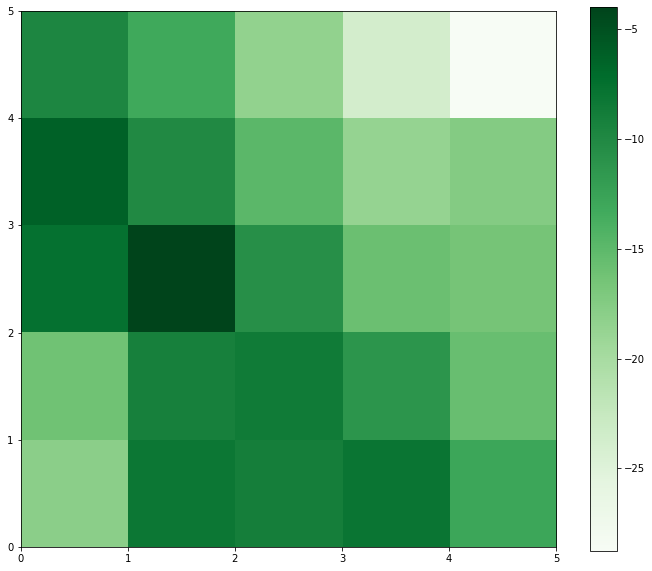

The maximum value is  -4.0  for the couple [ 18 ,  0.14 ]



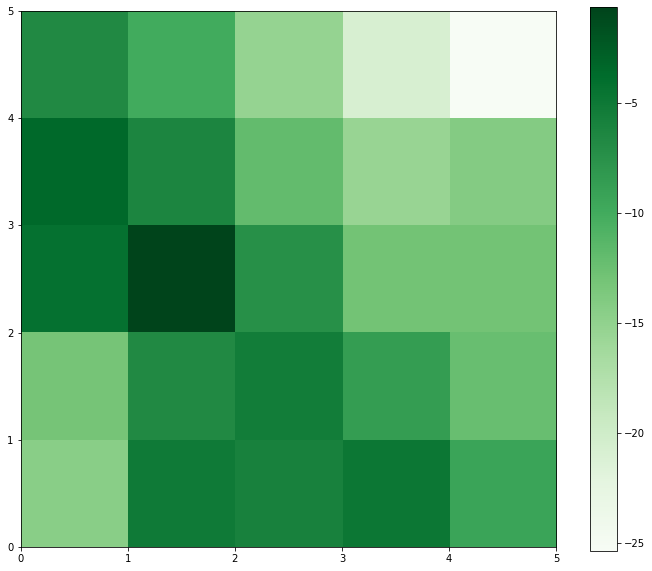

The maximum value is  -0.625  for the couple [ 18 ,  0.14 ]



In [6]:
StochasticModellingWithParameters()